# Partie 3 : Analyse comparative et optimisation

## A - Evaluation multi-modèles

In [30]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    pipeline, Trainer, TrainingArguments
)
from datasets import Dataset
import time
import psutil
import gc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

Device utilisé: cpu


## Modèles de classification

In [32]:
# DistilBERT-base-uncased
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
test_texts = [
    "I love this product, it's amazing and works perfectly!",
    "This is terrible, worst experience ever, completely disappointed",
    "Great service and excellent quality, highly recommend",
    "Disappointing results, not recommended, poor performance",
    "Outstanding performance, very satisfied with the purchase",
    "Poor quality, waste of money, regret buying this",
    "Excellent customer support, very helpful staff",
    "Very frustrating experience, technical issues everywhere",
    "Best purchase I've ever made, exceeded expectations",
    "Completely useless product, doesn't work as advertised",
    "Good value for money, decent quality overall",
    "Horrible customer service, unhelpful and rude staff",
    "Amazing features, easy to use, great design",
    "Faulty product, broke after one week of use",
    "Impressive results, better than expected quality"
]

test_labels = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

In [35]:
long_texts = [
    "This is a longer text to test the performance of both models on extended sequences. " * 10,
    "Another extended text sample that contains multiple sentences and should provide insights into model efficiency. " * 10,
    "Testing computational efficiency with longer input sequences to understand the trade-offs between model size and performance. " * 10
]

In [36]:
def measure_inference_time(model, tokenizer, texts, num_runs=3):
    """Mesure le temps d'inférence avec plusieurs runs"""
    all_times = []

    for _ in range(num_runs):
        times = []
        for text in texts:
            start_time = time.time()

            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = model(**inputs)

            end_time = time.time()
            times.append(end_time - start_time)

            # Nettoyage mémoire
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

        all_times.extend(times)

    return all_times

In [37]:
def get_model_size(model):
    """Calcule la taille du modèle en MB"""
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024**2

In [38]:
def count_parameters(model):
    """Compte le nombre de paramètres"""
    return sum(p.numel() for p in model.parameters())

In [39]:
def get_memory_usage():
    """Obtient l'utilisation mémoire actuelle"""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**2  # MB
    else:
        return psutil.Process().memory_info().rss / 1024**2  # MB

In [40]:
def evaluate_model(model, tokenizer, texts, labels):
    """Évalue les performances du modèle"""
    predictions = []
    confidences = []

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)
            prediction = torch.argmax(outputs.logits, dim=-1).item()
            confidence = torch.max(probs).item()

            predictions.append(prediction)
            confidences.append(confidence)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    avg_confidence = np.mean(confidences)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'avg_confidence': avg_confidence,
        'predictions': predictions
    }

In [41]:
print("\n=== ÉVALUATION DISTILBERT-BASE-UNCASED ===")

# Métriques de base
distilbert_params = count_parameters(distilbert_model)
distilbert_size = get_model_size(distilbert_model)

# Performance sur textes courts
distilbert_times_short = measure_inference_time(distilbert_model, distilbert_tokenizer, test_texts)
distilbert_results = evaluate_model(distilbert_model, distilbert_tokenizer, test_texts, test_labels)

# Performance sur textes longs
distilbert_times_long = measure_inference_time(distilbert_model, distilbert_tokenizer, long_texts)

print(f"DistilBERT - Nombre de paramètres: {distilbert_params:,}")
print(f"DistilBERT - Taille du modèle: {distilbert_size:.2f} MB")
print(f"DistilBERT - Temps moyen (textes courts): {np.mean(distilbert_times_short):.4f}s")
print(f"DistilBERT - Temps moyen (textes longs): {np.mean(distilbert_times_long):.4f}s")
print(f"DistilBERT - Accuracy: {distilbert_results['accuracy']:.3f}")
print(f"DistilBERT - F1-Score: {distilbert_results['f1']:.3f}")
print(f"DistilBERT - Confiance moyenne: {distilbert_results['avg_confidence']:.3f}")


=== ÉVALUATION DISTILBERT-BASE-UNCASED ===
DistilBERT - Nombre de paramètres: 66,955,010
DistilBERT - Taille du modèle: 255.42 MB
DistilBERT - Temps moyen (textes courts): 0.0127s
DistilBERT - Temps moyen (textes longs): 0.0449s
DistilBERT - Accuracy: 0.533
DistilBERT - F1-Score: 0.696
DistilBERT - Confiance moyenne: 0.542


In [42]:
print("\n=== ÉVALUATION BERT-BASE-UNCASED ===")

# Métriques de base
bert_params = count_parameters(bert_model)
bert_size = get_model_size(bert_model)

# Performance sur textes courts
bert_times_short = measure_inference_time(bert_model, bert_tokenizer, test_texts)
bert_results = evaluate_model(bert_model, bert_tokenizer, test_texts, test_labels)

# Performance sur textes longs
bert_times_long = measure_inference_time(bert_model, bert_tokenizer, long_texts)

print(f"BERT - Nombre de paramètres: {bert_params:,}")
print(f"BERT - Taille du modèle: {bert_size:.2f} MB")
print(f"BERT - Temps moyen (textes courts): {np.mean(bert_times_short):.4f}s")
print(f"BERT - Temps moyen (textes longs): {np.mean(bert_times_long):.4f}s")
print(f"BERT - Accuracy: {bert_results['accuracy']:.3f}")
print(f"BERT - F1-Score: {bert_results['f1']:.3f}")
print(f"BERT - Confiance moyenne: {bert_results['avg_confidence']:.3f}")


=== ÉVALUATION BERT-BASE-UNCASED ===


/home/arthur/Deep Learning/tp_transformers/.venv/Scripts/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


BERT - Nombre de paramètres: 109,483,778
BERT - Taille du modèle: 417.66 MB
BERT - Temps moyen (textes courts): 0.0273s
BERT - Temps moyen (textes longs): 0.0892s
BERT - Accuracy: 0.467
BERT - F1-Score: 0.000
BERT - Confiance moyenne: 0.631


In [43]:
comparison_data = {
    'Modèle': ['DistilBERT-base-uncased', 'BERT-base-uncased'],
    'Paramètres (M)': [distilbert_params/1e6, bert_params/1e6],
    'Taille (MB)': [distilbert_size, bert_size],
    'Temps inf. courts (s)': [np.mean(distilbert_times_short), np.mean(bert_times_short)],
    'Temps inf. longs (s)': [np.mean(distilbert_times_long), np.mean(bert_times_long)],
    'Accuracy': [distilbert_results['accuracy'], bert_results['accuracy']],
    'F1-Score': [distilbert_results['f1'], bert_results['f1']],
    'Precision': [distilbert_results['precision'], bert_results['precision']],
    'Recall': [distilbert_results['recall'], bert_results['recall']],
    'Confiance moy.': [distilbert_results['avg_confidence'], bert_results['avg_confidence']]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n=== TABLEAU COMPARATIF ===")
print(df_comparison.round(4))


=== TABLEAU COMPARATIF ===
                    Modèle  Paramètres (M)  Taille (MB)  \
0  DistilBERT-base-uncased         66.9550     255.4170   
1        BERT-base-uncased        109.4838     417.6553   

   Temps inf. courts (s)  Temps inf. longs (s)  Accuracy  F1-Score  Precision  \
0                 0.0127                0.0449    0.5333    0.6957     0.5333   
1                 0.0273                0.0892    0.4667    0.0000     0.0000   

   Recall  Confiance moy.  
0     1.0          0.5419  
1     0.0          0.6314  


In [44]:
# Ratio efficacité (performance/temps)
distilbert_efficiency = distilbert_results['f1'] / np.mean(distilbert_times_short)
bert_efficiency = bert_results['f1'] / np.mean(bert_times_short)

# Ratio compression (performance/taille)
distilbert_compression = distilbert_results['f1'] / distilbert_size
bert_compression = bert_results['f1'] / bert_size

print(f"\n=== RATIOS PERFORMANCE ===")
print(f"DistilBERT - Efficacité (F1/temps): {distilbert_efficiency:.2f}")
print(f"BERT - Efficacité (F1/temps): {bert_efficiency:.2f}")
print(f"DistilBERT - Compression (F1/taille): {distilbert_compression:.4f}")
print(f"BERT - Compression (F1/taille): {bert_compression:.4f}")


=== RATIOS PERFORMANCE ===
DistilBERT - Efficacité (F1/temps): 54.88
BERT - Efficacité (F1/temps): 0.00
DistilBERT - Compression (F1/taille): 0.0027
BERT - Compression (F1/taille): 0.0000


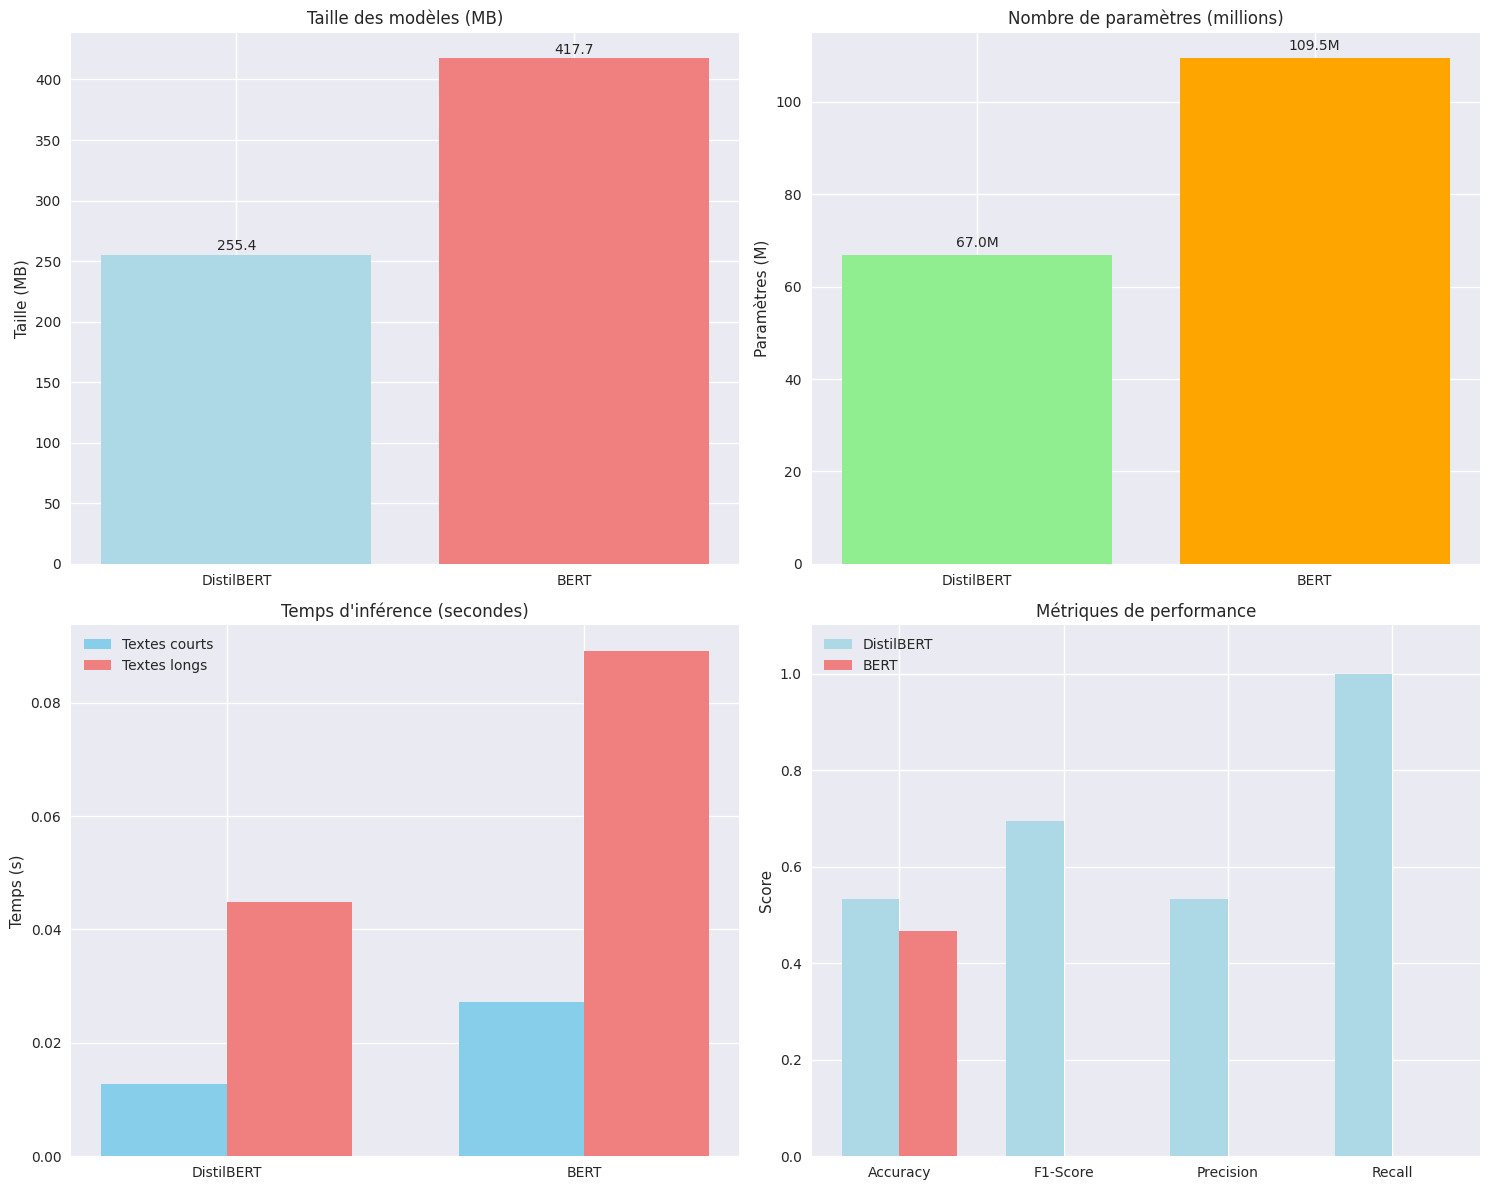

In [45]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Comparaison des tailles
models = ['DistilBERT', 'BERT']
sizes = [distilbert_size, bert_size]
params = [distilbert_params/1e6, bert_params/1e6]

axes[0,0].bar(models, sizes, color=['lightblue', 'lightcoral'])
axes[0,0].set_title('Taille des modèles (MB)')
axes[0,0].set_ylabel('Taille (MB)')
for i, v in enumerate(sizes):
    axes[0,0].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom')

# 2. Comparaison du nombre de paramètres
axes[0,1].bar(models, params, color=['lightgreen', 'orange'])
axes[0,1].set_title('Nombre de paramètres (millions)')
axes[0,1].set_ylabel('Paramètres (M)')
for i, v in enumerate(params):
    axes[0,1].text(i, v + 1, f'{v:.1f}M', ha='center', va='bottom')

# 3. Temps d'inférence
times_short = [np.mean(distilbert_times_short), np.mean(bert_times_short)]
times_long = [np.mean(distilbert_times_long), np.mean(bert_times_long)]

x = np.arange(len(models))
width = 0.35

axes[1,0].bar(x - width/2, times_short, width, label='Textes courts', color='skyblue')
axes[1,0].bar(x + width/2, times_long, width, label='Textes longs', color='lightcoral')
axes[1,0].set_title('Temps d\'inférence (secondes)')
axes[1,0].set_ylabel('Temps (s)')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models)
axes[1,0].legend()

# 4. Métriques de performance
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
distilbert_metrics = [distilbert_results['accuracy'], distilbert_results['f1'],
                     distilbert_results['precision'], distilbert_results['recall']]
bert_metrics = [bert_results['accuracy'], bert_results['f1'],
               bert_results['precision'], bert_results['recall']]

x = np.arange(len(metrics))
axes[1,1].bar(x - width/2, distilbert_metrics, width, label='DistilBERT', color='lightblue')
axes[1,1].bar(x + width/2, bert_metrics, width, label='BERT', color='lightcoral')
axes[1,1].set_title('Métriques de performance')
axes[1,1].set_ylabel('Score')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(metrics)
axes[1,1].legend()
axes[1,1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

In [46]:
print("\n=== ANALYSE DES TRADE-OFFS ===")
print(f"Réduction de taille: {((bert_size - distilbert_size) / bert_size * 100):.1f}%")
print(f"Réduction de paramètres: {((bert_params - distilbert_params) / bert_params * 100):.1f}%")
print(f"Gain de vitesse (textes courts): {(np.mean(bert_times_short) / np.mean(distilbert_times_short)):.2f}x")
print(f"Gain de vitesse (textes longs): {(np.mean(bert_times_long) / np.mean(distilbert_times_long)):.2f}x")
print(f"Différence de performance F1: {(bert_results['f1'] - distilbert_results['f1']):.3f}")

# Forces et faiblesses
print("\n=== FORCES ET FAIBLESSES ===")
print("\nDistilBERT:")
print("+ Plus rapide et léger")
print("+ Moins de mémoire requise")
print("+ Bon pour déploiement mobile/edge")
if distilbert_results['f1'] >= bert_results['f1']:
    print("+ Performance équivalente ou supérieure")
else:
    print("- Performance légèrement inférieure")

print("\nBERT:")
print("+ Modèle de référence, bien testé")
print("+ Potentiellement plus stable")
if bert_results['f1'] > distilbert_results['f1']:
    print("+ Meilleure performance")
else:
    print("- Performance équivalente")
print("- Plus lent et plus lourd")
print("- Plus de ressources requises")


=== ANALYSE DES TRADE-OFFS ===
Réduction de taille: 38.8%
Réduction de paramètres: 38.8%
Gain de vitesse (textes courts): 2.15x
Gain de vitesse (textes longs): 1.99x
Différence de performance F1: -0.696

=== FORCES ET FAIBLESSES ===

DistilBERT:
+ Plus rapide et léger
+ Moins de mémoire requise
+ Bon pour déploiement mobile/edge
+ Performance équivalente ou supérieure

BERT:
+ Modèle de référence, bien testé
+ Potentiellement plus stable
- Performance équivalente
- Plus lent et plus lourd
- Plus de ressources requises


## Modèles de génération de texte